In [47]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap, TyreRaceData, Team, DriverTeamSession, TeamCircuitStats

import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from itertools import product

# Initialize database connection
global db_session
engine, db_session = init_db()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [48]:
import pandas as pd
from sqlalchemy.orm import joinedload

def get_race_df(year, circuit):
	race_session = (db_session.query(Session)
					.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
					.join(Circuit, RacingWeekend.circut_id == Circuit.circuit_id)
					.filter(
						RacingWeekend.year == year,
						Circuit.circuit_name == circuit,
						Session.session_type == 'Race'
					)
					.first())

	# Fetch all laps for this session, ordered by lap number and position
	laps = (db_session.query(Lap)
			.options(joinedload(Lap.driver))
			.filter(Lap.session_id == race_session.session_id)
			.order_by(Lap.lap_num, Lap.position)
			.all())

	# Convert to DataFrame
	laps_data = []
	for lap in laps:
		laps_data.append({
			'lap_num': lap.lap_num,
			'position': lap.position,
			'driver_name': lap.driver.driver_name,
			'driver_number': lap.driver.driver_num,
			'lap_time': lap.lap_time,
			'tyre': lap.tyre,
			'tyre_laps': lap.tyre_laps,
			'pit': lap.pit,
		})

	df = pd.DataFrame(laps_data)

	return df
def race_df_extra_info(df):
	# Ensure DataFrame is sorted
	df.sort_values(by=['lap_num', 'position'], inplace=True)

	# ------------------------------------------------------------------------------ 
	# STEP 1: Calculate cumulative race time for each driver up to each lap
	# ------------------------------------------------------------------------------ 
	df["cumulative_time"] = df.groupby("driver_name")["lap_time"].cumsum()

	# ------------------------------------------------------------------------------ 
	# STEP 2: Find the car ahead's cumulative time for each lap
	# ------------------------------------------------------------------------------ 
	# Get car ahead's cumulative time (car immediately ahead in position for each lap)
	df["front_cumulative_time"] = df.groupby("lap_num")["cumulative_time"].shift(1)

	# ------------------------------------------------------------------------------ 
	# STEP 3: Calculate gap to car ahead (cumulative difference)
	# ------------------------------------------------------------------------------ 
	# This gap is calculated only for drivers who are not in the lead position (position > 1)
	df["gap"] = df["cumulative_time"] - df["front_cumulative_time"]
	df["gap"] = df["gap"].fillna(0)  # Leader has no car ahead, so gap is 0

	# ------------------------------------------------------------------------------ 
	# STEP 4: Calculate tyre difference (compared to car immediately ahead in THIS LAP)
	# ------------------------------------------------------------------------------ 
	df["front_tyre"] = df.groupby("lap_num")["tyre"].shift(1)
	df["tyre_diff"] = df["front_tyre"] - df["tyre"]
	df["tyre_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# ------------------------------------------------------------------------------ 
	# STEP 4: Calculate tyre age difference (compared to car immediately ahead in THIS LAP)
	# ------------------------------------------------------------------------------ 
	df["front_laps"] = df.groupby("lap_num")["tyre_laps"].shift(1)
	df["tyre_age_diff"] = df["front_laps"] - df["tyre_laps"]
	df["tyre_age_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# ------------------------------------------------------------------------------ 
	# STEP 5: Calculate DRS availability (within 1s of car ahead IN THIS LAP)
	# ------------------------------------------------------------------------------ 
	df["front_lap_time"] = df.groupby("lap_num")["lap_time"].shift(1)
	df["drs_available"] = (df["lap_time"] - df["front_lap_time"]).abs() <= 1
	df["drs_available"] = df["drs_available"] & (df["position"] > 1)  # Leader can't have DRS

	# ------------------------------------------------------------------------------ 
	# Cleanup and final sorting
	# ------------------------------------------------------------------------------ 
	df = df.drop(columns=["front_cumulative_time", "front_tyre", "front_lap_time"])
	df["gap"] = df["gap"].round(3)  # Round to 3 decimal places
	df = df.sort_values(["lap_num", "position"])



	# Create target variable (1 if position improved next lap, 0 otherwise)
	df['next_position'] = df.groupby('driver_name')['position'].shift(-1)
	df['overtake'] = ((df['next_position'] < df['position']) | 
					(df['next_position'].isna())).astype(int)


	# df['tyre_age_diff'] = df.groupby('driver_name')['tyre_laps'].diff().fillna(0)

	# Cleanup
	df = df.dropna(subset=['next_position'])

	return df

df_2022 = get_race_df(2022, "Sakhir")
df_2022 = race_df_extra_info(df_2022)

# df_2022

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight

# Define features and target
features = [
	'gap',
	'tyre_diff',
	'tyre_age_diff',
	'drs_available',
	'lap_num',
	'pit',
	'cumulative_time'
]
X = df_2022[features]
y = df_2022['overtake']

# Handle missing values
X = X.fillna(X.mean())

sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# Base model
gbc = GradientBoostingClassifier(
	n_estimators=200,
	learning_rate=0.05,
	max_depth=3,
	subsample=0.8,
	random_state=42
)

# Calibrate for better probabilities
model = CalibratedClassifierCV(gbc, method='isotonic', cv=3)

# Train on all data
model.fit(X, y, sample_weight=sample_weights)

# ------------------------------------------------------------------------------ 
# Step 3: Create a prediction function
# ------------------------------------------------------------------------------ 

def predict_overtake(new_race_df):
	# Select the same features used during training
	X_new = new_race_df[features]
	
	# Handle missing values (if any)
	X_new = X_new.fillna(X.mean())
	
	# Make predictions using the trained model
	new_race_df['predicted_overtake'] = (model.predict_proba(X_new)[:, 1] >= 0.5).astype(int)
	
	return new_race_df

XGBClassifier could also be good

In [50]:
from sklearn.metrics import accuracy_score, classification_report
df_2023 = get_race_df(2024, "Sakhir")
df_2023 = race_df_extra_info(df_2023)

new_race_df = predict_overtake(df_2023)

# Calculate accuracy
actual_overtakes = new_race_df['overtake']
predicted_overtakes = new_race_df['predicted_overtake']
accuracy = accuracy_score(actual_overtakes, predicted_overtakes)
print(f"Accuracy: {accuracy:.3f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(
	actual_overtakes,
	predicted_overtakes,
	target_names=['No Overtake', 'Overtake']
))

df_2022.head(5)

Accuracy: 0.812

Classification Report:
              precision    recall  f1-score   support

 No Overtake       0.91      0.86      0.89       954
    Overtake       0.37      0.50      0.42       153

    accuracy                           0.81      1107
   macro avg       0.64      0.68      0.66      1107
weighted avg       0.84      0.81      0.82      1107



,lap_num,position,driver_name,driver_number,lap_time,tyre,tyre_laps,pit,cumulative_time,gap,tyre_diff,front_laps,tyre_age_diff,drs_available,next_position,overtake
0,1,1,Charles Leclerc,16,99.070,1,1,False,99.070,0.000,0.0,NaN,0.0,False,1.0,0
1,1,2,Max Verstappen,33,100.236,1,4,False,100.236,1.166,0.0,1.0,0.0,False,2.0,0
2,1,3,Carlos Sainz,55,101.006,1,4,False,101.006,0.770,0.0,4.0,0.0,True,3.0,0
3,1,4,Lewis Hamilton,44,101.555,1,3,False,101.555,0.549,0.0,4.0,0.0,True,4.0,0
4,1,5,Kevin Magnussen,20,102.333,1,1,False,102.333,0.778,0.0,3.0,0.0,True,5.0,0


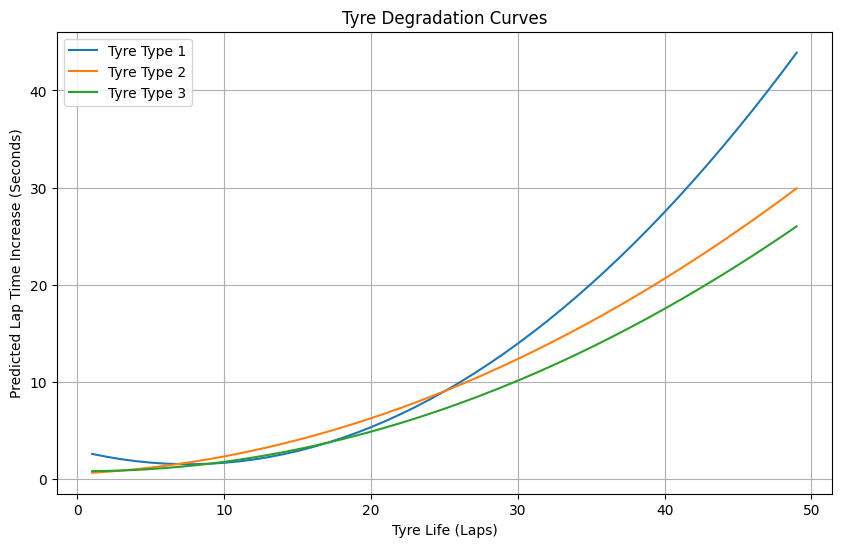

In [51]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Function Definitions
def correct_fuel_effect(df, max_lap=None, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Find the maximum number of laps completed by any driver in the race
	if max_lap is None:
		max_lap = df['lap_num'].max()

	# Group by driver to process each driver's laps individually
	def _correct_fuel_for_driver(driver_df):
		# Make sure we modify the original DataFrame using .loc to avoid SettingWithCopyWarning
		driver_df.loc[:, 'fuel_weight'] = max_fuel_kg - (driver_df['lap_num'] - 1) * (max_fuel_kg / max_lap)
		driver_df.loc[:, 'fuel_correction'] = driver_df['fuel_weight'] * fuel_effect_per_kg
		driver_df.loc[:, 'fuel_corrected_lap_time'] = driver_df['lap_time'] - driver_df['fuel_correction']
		return driver_df

	# Apply the correction to each driver's laps using groupby and avoid deprecated behavior with group_keys=False
	df = df.groupby('driver_number', group_keys=False)[df.columns].apply(_correct_fuel_for_driver).reset_index(drop=True)
	return df


def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df['stint'] = np.nan
	for driver in df['driver_number'].unique():
		driver_data = df[df['driver_number'] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	df['stint'] = df['stint'].astype(int)
	return df

def remove_laps_outside_percent(df, percentage=5):
	# Group by driver and apply the filtering logic to each driver's laps
	def _filter_driver_laps(driver_df):
		# Calculate the threshold based on the fastest lap time for the driver
		fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
		threshold = fastest_lap_time * (1 + percentage / 100)

		# Remove laps not within the specified percentage of the fastest lap time
		driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= threshold]

		return driver_df

	# Apply the filtering logic to each driver's laps
	df = df.groupby('driver_number')[df.columns].apply(_filter_driver_laps).reset_index(drop=True)

	return df

def normalise_lap_times(df):
	# Group by driver and calculate the fastest lap time for each driver
	df['fastest_lap_time'] = df.groupby('driver_number')['fuel_corrected_lap_time'].transform('min')

	# Normalise lap times by subtracting the fastest lap time
	df['normalised_lap_time'] = df['fuel_corrected_lap_time'] - df['fastest_lap_time']

	# Drop the fastest_lap_time as it's no longer needed
	df = df.drop(columns=['fastest_lap_time'])

	return df

def get_tyre_deg(df):
	# Normalize lap times
	df = assign_stint_numbers(df)
	df = correct_fuel_effect(df)
	df = remove_laps_outside_percent(df)
	df = normalise_lap_times(df)

	# Define minimum laps required for each tyre type
	min_laps_by_tyre = {
		1: 3,    # Tyre Type 1 (e.g., Soft)
		2: 5,   # Tyre Type 2 (e.g., Medium)
		3: 7   # Tyre Type 3 (e.g., Hard)
	}

	# Dictionary to store all coefficients for each tyre type
	all_tyre_coefficients = {tyre: [] for tyre in min_laps_by_tyre.keys()}

	# Process each driver
	for driver in df['driver_number'].unique():
		# Filter data for the current driver
		df_driver = df[df['driver_number'] == driver]
		
		# Group by tyre type
		for tyre in df_driver['tyre'].unique():
			tyre_data = df_driver[df_driver['tyre'] == tyre]
			
			# Group by stint to handle multiple stints with the same tyre type
			for stint, stint_data in tyre_data.groupby('stint'):
				# Check if the stint meets the minimum lap requirement for the tyre type
				min_laps = min_laps_by_tyre.get(tyre, 0)  # Default to 0 if tyre type not in dictionary
				if len(stint_data) < min_laps:
					continue
				
				# Fit a polynomial of degree 2
				x = stint_data['tyre_laps'].values.reshape(-1, 1)  # Tyre laps as x-axis
				y = stint_data['normalised_lap_time'].values      # Normalized lap times as y-axis
				poly = PolynomialFeatures(degree=2)
				x_poly = poly.fit_transform(x)
				model = LinearRegression()
				model.fit(x_poly, y)
				
				# Store the coefficients (a, b, c) for the polynomial ax^2 + bx + c
				coefficients = [model.coef_[2], model.coef_[1], model.intercept_]  # [a, b, c]
				all_tyre_coefficients[tyre].append(coefficients)

	# Average coefficients for each tyre type
	averaged_coefficients = {}
	for tyre, coefficients_list in all_tyre_coefficients.items():
		if coefficients_list:  # Check if there are coefficients for this tyre type
			averaged_coefficients[tyre] = np.mean(coefficients_list, axis=0).tolist()


	return averaged_coefficients

deg_2022 = (get_tyre_deg(df_2022))

import matplotlib.pyplot as plt

def plot_tyre_degradation(coefficients_dict):
	# Generate x values (tyre life in laps)
	x = range(1, 50)  # Assume tyre life up to 30 laps
	
	# Create a new figure
	plt.figure(figsize=(10, 6))
	
	# Plot each tyre type
	for tyre_type, coeffs in coefficients_dict.items():
		a, b, c = coeffs
		y = [a * xi**2 + b * xi + c for xi in x]
		plt.plot(x, y, label=f"Tyre Type {tyre_type}")
	
	# Add labels and legend
	plt.title("Tyre Degradation Curves")
	plt.xlabel("Tyre Life (Laps)")
	plt.ylabel("Predicted Lap Time Increase (Seconds)")
	plt.legend()
	plt.grid(True)
	
	# Show the plot
	plt.show()

plot_tyre_degradation(deg_2022)

## New race prediction

* take the race in lap by lap, with current positions and gaps on that lap
* then look ahead for 10 laps, with a simulation pitting on every one of those laps - also x3 as doing it with each tyre type
	* within those simulations we simualate the position we would be at - take the pit lap with the highest position at the end
* for other cars within the simualtion, we take the regression of each past laptimes and use historic ones (last 30 races), we can average the regressions (weighted slightly more to one maybe?)
	* we then just minimise their total race time to find out if they pit within the 10 laps (what lap they pit on)
* We can then plug this into our simulation for each lap, getting an approx of where cars will be and traffic and such

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_current_deg(df, total_laps):
	df = correct_fuel_effect(df, max_lap=total_laps)
	df = assign_stint_numbers(df)
	df = remove_laps_outside_percent(df)
	df = normalise_lap_times(df)

	current_stint = df['stint'].max()
	current_stint_data = df[df['stint'] == current_stint]
	tyre = current_stint_data["tyre"].iloc[0]

	if len(current_stint_data) < 5:
		print("Not enough data in the current stint to perform regression.")
		return -1
	
	# Prepare data for regression
	x = current_stint_data['tyre_laps'].values.reshape(-1, 1)  # Tyre life (laps in the stint)
	y = current_stint_data['normalised_lap_time'].values       # Normalized lap times
	
	# Fit a polynomial regression model (degree 2)
	poly = PolynomialFeatures(degree=2)
	x_poly = poly.fit_transform(x)
	model = LinearRegression()
	model.fit(x_poly, y)

	return {tyre: {"a": {model.coef_[2]}, "b": {model.coef_[1]}, "c": {model.intercept_}}} # [a, b, c]



def race_sim(race_df, current_lap, total_laps):
	# for all laps left
	# 	find times for each driver
	# 	pit if its their pit lap (guessed)
	# 	simulate overtakes if within 2 seconds
	# 	then got final df/rest of race
	race_df = correct_fuel_effect(race_df, max_lap=total_laps)
	
	# for each driver, find min fuel time (base time)
	# then loop over each remaing lap, calcualte time, pit if they pit.
	# then if within 2 seconds just put a placeholder for now for "overtake"

	
	# Get unique drivers
	drivers = race_df[race_df["lap_num"]==current_lap]["driver_number"].unique()
	
	base_laptimes = {}
	driver_names = {}
	for driver in drivers:
		base_time = race_df[race_df["driver_number"] == driver]["fuel_corrected_lap_time"].min()
		driver_name = race_df[race_df["driver_number"] == driver]["driver_name"].iloc[0]

		driver_names[driver] = driver_name
		base_laptimes[driver] = base_time

	simulated_data = []

	
	# Initialize cumulative times and positions for all drivers
	cumulative_times = {driver: race_df[(race_df["driver_number"] == driver) & 
										(race_df["lap_num"] == current_lap)]["cumulative_time"].values[0]
						for driver in drivers}
	positions = {driver: race_df[(race_df["driver_number"] == driver) & 
								 (race_df["lap_num"] == current_lap)]["position"].values[0]
				for driver in drivers}
	tyre_types = {driver: race_df[(race_df["driver_number"] == driver) & 
								  (race_df["lap_num"] == current_lap)]["tyre"].values[0]
				 for driver in drivers}
	tyre_laps = {driver: race_df[(race_df["driver_number"] == driver) & 
								 (race_df["lap_num"] == current_lap)]["tyre_laps"].values[0]
				for driver in drivers}
	
	# Predict pit laps (placeholder logic: assume pitting every 20 laps)
	pit_laps = list(range(20, total_laps, 20))

	# Simulate each lap from current_lap + 1 to total_laps
	for lap in range(current_lap + 1, total_laps + 1):
		lap_data = []  # Temporary storage for this lap's data
		
		for driver in drivers:
			# Increment tyre life
			tyre_laps[driver] += 1
			
			# Get tyre degradation coefficients for the current tyre type
			a, b, c = deg_2022[tyre_types[driver]]
			
			# Predict lap time using tyre degradation model and base lap time
			lap_time = base_laptimes[driver] + (a * tyre_laps[driver]**2 + b * tyre_laps[driver] + c)
			
			max_fuel_kg = 110
			fuel_effect_per_kg = 0.03
			fuel_weight = max_fuel_kg - (lap - 1) * (max_fuel_kg / total_laps)
			fuel_correction = fuel_weight * fuel_effect_per_kg
			lap_time += fuel_correction  # Add fuel correction back

			# Check if it's a pit lap
			if lap in pit_laps:
				lap_time += 20  # Add pit stop time penalty
				tyre_laps[driver] = 1  # Reset tyre life after pit stop
				tyre_types[driver] = 2  # Assume switching to tyre type 1 (e.g., Soft tyres) after pit stop
			
			# Update cumulative time
			cumulative_times[driver] += lap_time
			
			# Store temporary data for this lap
			lap_data.append({
				"lap_num": lap,
				"driver_name": driver_names[driver],
				"driver_number": driver,
				"cumulative_time": cumulative_times[driver],
				"position": positions[driver],  # Placeholder, will update later
				"lap_time": lap_time,
				"tyre_laps": tyre_laps[driver],
				"tyre": tyre_types[driver],
				"pit": lap in pit_laps,
				"overtake": False  # Placeholder, will update later
			})
		
		# Convert lap_data to a DataFrame for overtaking simulation
		lap_df = pd.DataFrame(lap_data)
		
		# Sort by cumulative time to determine positions
		lap_df['position'] = lap_df['cumulative_time'].rank(method='min').astype(int)
		
		consecutive_laps_within_2_seconds = {driver: 0 for driver in drivers}

		# Simulate overtakes
		for i, row in lap_df.iterrows():
			
			driver = row['driver_number']
			position = row['position']
			
			# Skip if the driver is in first place (no one to overtake)
			if position == 1:
				continue
			
			# Find the driver ahead
			driver_ahead = lap_df[lap_df['position'] == position - 1]
			if driver_ahead.empty:
				continue
			
			# Calculate gap to the driver ahead
			gap = cumulative_times[driver] - cumulative_times[driver_ahead['driver_number'].values[0]]

			lap_df.at[i, 'gap'] = gap

			if gap <= 2:
				consecutive_laps_within_2_seconds[driver] += 1

		
				# Determine DRS availability
				drs_available = gap <= 1.0  # DRS is available if within 1 second
				
				# Prepare features for overtake prediction
				features_dict = {
					'gap': gap,
					'tyre_diff': tyre_types[driver] - tyre_types[driver_ahead['driver_number'].values[0]],
					'tyre_age_diff': tyre_laps[driver] - tyre_laps[driver_ahead['driver_number'].values[0]],
					'drs_available': drs_available,
					'lap_num': lap,
					'pit': lap in pit_laps,
					'cumulative_time': cumulative_times[driver]
				}
				features_df = pd.DataFrame([features_dict])
				

				# Predict overtake
				features_df = predict_overtake(features_df)
				overtake = features_df['predicted_overtake'].values[0]
				
				if consecutive_laps_within_2_seconds[driver] >= 4:
					overtake = True
				
				# If overtake is successful, swap positions
				if overtake:
					# PROBLEM with cummalitive and lap by lap times not adding up - fix TODO

					# Swap cumulative times and positions
					cumulative_times[driver], cumulative_times[driver_ahead['driver_number'].values[0]] = (
						cumulative_times[driver_ahead['driver_number'].values[0]], cumulative_times[driver]
					)
					positions[driver], positions[driver_ahead['driver_number'].values[0]] = (
						positions[driver_ahead['driver_number'].values[0]], positions[driver]
					)
					lap_df.at[i, 'overtake'] = True

				else:
					if cumulative_times[driver] < cumulative_times[driver_ahead['driver_number'].values[0]]:
						cumulative_times[driver] = cumulative_times[driver_ahead['driver_number'].values[0]] + 0.2

			else:
				consecutive_laps_within_2_seconds[driver] = 0
		
		# Append lap data to simulated_data
		simulated_data.extend(lap_df.to_dict(orient='records'))
	
	# Convert simulated data to a DataFrame
	simulated_df = pd.DataFrame(simulated_data)
	
	# Combine original race_df with simulated_df
	final_df = pd.concat([race_df, simulated_df], ignore_index=True)
	final_df.sort_values(by=['lap_num', 'position'], inplace=True)


	# final_df = race_df_extra_info(final_df)
	return final_df
	
		
	
# def race_strategy(race_df, current_lap, total_laps, driver_num):
# 	# so we sim rest of race, we know the current lap we're on
# 	# we find out how he currently is on his tyres so far
# 	# we predict future laps using tyre deg so far, and find the most optimal pit lap given simulation again
# 	# we just predict the next pit stop, store each predicted lap until they actually pit or we hit the same lap as predicted in the prediction
# 	driver_df = race_df[race_df["driver_number"]==driver_num]
# 	deg = get_current_deg(driver_df, total_laps)
# 	if deg == -1:
# 		print("no deg data")
# 		return

# 	tyre_type = list(deg.keys())[0]
# 	a, b, c = list(deg[tyre_type]["a"])[0], list(deg[tyre_type]["b"])[0], list(deg[tyre_type]["c"])[0]

# 	sim_df = race_sim(current_lap_data, current_lap, total_laps)

# 	reduced_driver_df = sim_df[~((sim_df["driver_number"] == driver_num) & (sim_df["lap_num"] > current_lap))]
	

# 	base_time = reduced_driver_df[reduced_driver_df["driver_number"] == driver_num]["fuel_corrected_lap_time"].min()
# 	driver_name = reduced_driver_df[reduced_driver_df["driver_number"] == driver_num]["driver_name"].iloc[0]
	


	


# total_laps = df_2023["lap_num"].max()
# global deg_2022
# deg_2022 = (get_tyre_deg(df_2022))

# for current_lap in range(1, total_laps + 1):
# 	current_lap_data = df_2023[df_2023["lap_num"] <= current_lap]
	
# 	print(f"For lap {current_lap}: {race_strategy(current_lap_data, current_lap, total_laps, 16)}")

	# if current_lap == 35:
	# 	test = race_strategy(current_lap_data, current_lap, total_laps, 16)

# df[df["lap_num"]==56]
# (test)

# (test)



In [55]:
import random

def race_strategy(race_df, current_lap, total_laps, driver_num):
    """
    Predict the optimal pit stop strategy for the remainder of the race starting from the current lap.
    """
    # Extract data for the specific driver
    driver_df = race_df[race_df["driver_number"] == driver_num]
    
    # Get tyre degradation coefficients for the current stint
    deg = get_current_deg(driver_df, total_laps)
    if deg == -1:
        print("No degradation data available.")
        return
    
    # Extract tyre type and degradation coefficients
    tyre_type = list(deg.keys())[0]
    a, b, c = list(deg[tyre_type]["a"])[0], list(deg[tyre_type]["b"])[0], list(deg[tyre_type]["c"])[0]
    
    # Simulate the rest of the race
    sim_df = race_sim(race_df, current_lap, total_laps)
    
    # Run the genetic algorithm to find the optimal pit stop strategy
    best_strategy, best_position = genetic_algorithm(sim_df, total_laps, driver_num)
    
    # Return the optimal strategy and final position
    return {
        "optimal_pit_stop_strategy": best_strategy,
        "final_position": best_position
    }

# Define the genetic algorithm parameters
POPULATION_SIZE = 50
GENERATIONS = 30
MUTATION_RATE = 0.1
MAX_PIT_STOPS = 4

def generate_random_strategy(current_lap, total_laps):
    """Generate a random pit stop strategy starting from the current lap."""
    num_pit_stops = random.randint(1, MAX_PIT_STOPS)
    pit_laps = sorted(random.sample(range(current_lap + 1, total_laps), num_pit_stops))
    return pit_laps

def simulate_strategy(strategy, race_df, total_laps, driver_num):
    """Simulate the race with a given pit stop strategy."""
    # Simulate the race using the provided strategy
    simulated_df = race_sim(race_df, current_lap=1, total_laps=total_laps)
    
    # Extract data for the specific driver
    driver_data = simulated_df[simulated_df["driver_number"] == driver_num]
    
    # Get the final position of the driver
    final_position = driver_data.iloc[-1]["position"]
    
    return final_position

def fitness_function(strategy, race_df, total_laps, driver_num):
    """Evaluate the fitness of a strategy based on final position."""
    final_position = simulate_strategy(strategy, race_df, total_laps, driver_num)
    return -final_position  # Negative because lower positions are better

def selection(population, fitness_scores):
    """Select parents for reproduction using tournament selection."""
    selected_parents = []
    for _ in range(len(population)):
        candidates = random.sample(list(zip(population, fitness_scores)), 2)
        winner = max(candidates, key=lambda x: x[1])[0]
        selected_parents.append(winner)
    return selected_parents

def crossover(parent1, parent2):
    """Perform crossover between two parents to produce offspring."""
    if not parent1 or not parent2:
        return parent1 or parent2
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1 = sorted(parent1[:crossover_point] + parent2[crossover_point:])
    child2 = sorted(parent2[:crossover_point] + parent1[crossover_point:])
    return child1, child2

def mutate(strategy, current_lap, total_laps):
    """Mutate a strategy by randomly adding, removing, or modifying a pit stop."""
    if random.random() < MUTATION_RATE:
        mutation_type = random.choice(["add", "remove", "modify"])
        if mutation_type == "add" and len(strategy) < MAX_PIT_STOPS:
            new_lap = random.choice([lap for lap in range(current_lap + 1, total_laps) if lap not in strategy])
            strategy.append(new_lap)
        elif mutation_type == "remove" and len(strategy) > 1:
            strategy.pop(random.randint(0, len(strategy) - 1))
        elif mutation_type == "modify":
            idx = random.randint(0, len(strategy) - 1)
            strategy[idx] = random.choice([lap for lap in range(current_lap + 1, total_laps) if lap not in strategy])
        strategy.sort()
    return strategy

def genetic_algorithm(race_df, total_laps, driver_num):
    """Run the genetic algorithm to find the optimal pit stop strategy."""
    population = [generate_random_strategy(current_lap, total_laps) for _ in range(POPULATION_SIZE)]
    
    for generation in range(GENERATIONS):
        fitness_scores = [fitness_function(strategy, race_df, total_laps, driver_num) for strategy in population]
        best_fitness = max(fitness_scores)
        best_strategy = population[np.argmax(fitness_scores)]
        print(f"Generation {generation}: Best Fitness = {-best_fitness}, Strategy = {best_strategy}")
        
        parents = selection(population, fitness_scores)
        next_generation = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i + 1]
            child1, child2 = crossover(parent1, parent2)
            next_generation.append(mutate(child1, current_lap, total_laps))
            next_generation.append(mutate(child2, current_lap, total_laps))
        
        population = next_generation
    
    best_fitness = max(fitness_scores)
    best_strategy = population[np.argmax(fitness_scores)]
    return best_strategy, -best_fitness

# Main loop over each lap
total_laps = df_2023["lap_num"].max()
global deg_2022
deg_2022 = (get_tyre_deg(df_2022))

for current_lap in range(1, total_laps + 1):


    if current_lap == 10:
        current_lap_data = df_2023[df_2023["lap_num"] <= current_lap]
        result = race_strategy(current_lap_data, current_lap, total_laps, 16)
        print(f"For lap {current_lap}: {result}")


Generation 0: Best Fitness = 4, Strategy = [29, 31, 36]


ValueError: empty range for randrange() (1, 1, 0)

im thinking of some sort of greedy algorithm. Lets say im optimising for one driver in a full race and i look at pitting for one of the next 10 laps, so i simulate pitting on each of those laps and then simulate 